## **Proyecto: Marketing bancario**

- **Recurso:** S. Moro, P. Rita, P. Cortez (2012). Los datos están relacionados con campañas de marketing directo (llamadas telefónicas) de una institución bancaria portuguesa. DOI: [10.24432/C5K306](https://archive.ics.uci.edu/dataset/222/bank+marketing)
- **Donado:** 2/13/2012
- **URL:** https://archive.ics.uci.edu/dataset/222/bank+marketing
- **Objetivo:** Es predecir si el cliente suscribirá un depósito a plazo (variable y).

**Paper introductorio**
- Un enfoque basado en datos para predecir el éxito del telemarketing bancario
- Por Sérgio Moro, P. Cortez, P. Rita . 2014
- Publicado en Sistemas de apoyo a la toma de decisiones

**Información adicional**

Los datos están relacionados con campañas de marketing directo de una institución bancaria portuguesa. Las campañas de marketing se basaron en llamadas telefónicas. A menudo, se requirió más de un contacto con el mismo cliente, para acceder si el producto (depósito a plazo bancario) sería ('sí') o no ('no') suscrito. Hay cuatro conjuntos de datos: 
1) bank-additional-full.csv con todos los ejemplos (41188) y 20 entradas, ordenados por fecha (de mayo de 2008 a noviembre de 2010), muy cerca de los datos analizados en [Moro et al., 2014] 
2) bank-additional.csv con el 10% de los ejemplos (4119), seleccionados aleatoriamente de 1), y 20 entradas. 
3) bank-full.csv con todos los ejemplos y 17 entradas, ordenados por fecha (versión anterior de este conjunto de datos con menos entradas). 
4) bank.csv con el 10% de los ejemplos y 17 entradas, seleccionadas aleatoriamente de 3 (versión anterior de este conjunto de datos con menos entradas). Los conjuntos de datos más pequeños se proporcionan para probar algoritmos de aprendizaje automático que requieren más recursos computacionales (por ejemplo, SVM). El objetivo de la clasificación es predecir si el cliente suscribirá (sí/no) un depósito a plazo (variable y).

**Marketing Introduction:**

The process by which companies create value for customers and build strong customer relationships in order to capture value from customers in return.

Kotler and Armstrong (2010).

**License**

Este conjunto de datos está licenciado bajo una licencia [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/legalcode) (CC BY 4.0).

Esto permite compartir y adaptar los conjuntos de datos para cualquier propósito, siempre que se otorgue el crédito correspondiente.

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Decission Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            classification_report)

import requests
from io import StringIO

## **1. Cargar datos**
**Objetivo:** Obtener los datos de la fuente y una primera visión de las propiedades, más una presentación.

In [2]:
df_raw = pd.read_csv('../data/raw_2/bank-full.csv', sep=';')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
df_raw.sample(10, random_state=42)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no
30813,28,blue-collar,married,secondary,no,1134,no,no,cellular,9,feb,130,3,-1,0,unknown,no
35463,24,management,single,tertiary,no,1085,no,yes,cellular,7,may,95,6,-1,0,unknown,no
31382,37,admin.,single,secondary,no,127,no,no,cellular,23,mar,83,4,-1,0,unknown,no
16904,30,blue-collar,single,secondary,no,3,yes,no,cellular,25,jul,51,1,-1,0,unknown,no
11930,38,technician,single,secondary,no,258,no,yes,unknown,20,jun,587,2,-1,0,unknown,no


## **Diccionario de datos**

|Nombre de la variable|	Role|	Tipo|	Demográfico|	Descripción|	Unidades|	Valores faltantes|
|---------------------|-----|-------|--------------|---------------|------------|--------------------|
|**age** / edad|	Característica|	Entero|	Edad|	|	|	 No|
|**job** / trabajo|	Característica|	Categórico|	Ocupación|	tipo de trabajo (categórico: 'administrador', 'obrero', 'empresario', 'empleado doméstico', 'gerente', jubilado', 'autónomo', 'servicios', 'estudiante', 'técnico', 'desempleado', 'desconocido')|	|	No|
|**marital** / marital|	Característica|	Categórico|	Estado civil|	estado civil (categórico: 'divorciado', 'casado', 'soltero', 'desconocido'; nota: 'divorciado' significa divorciado o viudo)|	|	No|
|**education** / educación|	Característica|	Categórico|	Nivel de educación|	(categórico: 'básico.4a', 'básico.6a', 'básico.9a', 'bachillerato', 'analfabeto', 'curso profesional', 'título universitario', 'desconocido')|	|	No|
|**default** / por defecto|	Característica|	Binario|	|	¿tiene crédito en mora?|	|	No|
|**balance** / balance|	Característica|	Entero|	|	saldo medio anual|	euros |	No|
|**housing** / alojamiento|	Característica|	Binario|	|	¿Tiene préstamo de vivienda?|	|	No|
|**loan** / préstamo|	Característica|	Binario|	|	¿Tiene préstamo personal?|	|	No|
|**contact** / contacto|	Característica|	Categórico|	|Tipo de comunicación de contacto (categórica: 'celular', 'teléfono')|	|	Sí|
|**day_of_week** / día_de_la_semana|	Característica|	Fecha|	|	último día de contacto de la semana|	|	No|
|**month** / mes|	Característica|	Fecha|	|	último mes de contacto del año (categórico: 'jan', 'feb', 'mar', ..., 'nov', 'dic')|	|	No|
|**duration** / duración|	Característica|	Entero|	|	Duración del último contacto, en segundos (numérico). Nota importante: este atributo afecta en gran medida el resultado final (por ejemplo, si la duración es 0, entonces y es "no"). Sin embargo, la duración no se conoce antes de que se realice una llamada. Además, después del final de la llamada, obviamente se conoce y. Por lo tanto, esta entrada solo se debe incluir con fines de referencia y se debe descartar si la intención es tener un modelo predictivo realista.|	|	No|
|**campaign** / campaña|	Característica|	Entero|	|	Número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)|	|	No|
|**pdays** / p días|	Característica|	Entero|	|	Número de días transcurridos desde que se contactó por última vez al cliente de una campaña anterior (numérico; -1 significa que el cliente no fue contactado previamente)|	|	Sí|
|**previous** / anterior|	Característica|	Entero| |	Número de contactos realizados antes de esta campaña y para este cliente.|	|	No|
|**poutme** / resultado|	Característica|	Categórico|	|	resultado de la campaña de marketing anterior (categórico: 'fracaso', 'inexistente', 'éxito')|	|	Sí|
|**y** / y|	Objetivo|	Binario|	|	¿El cliente ha suscrito un depósito a plazo?|	|	No|

## **2. Preprocesamiento de datos**

**Objetivo:** Realizar los pasos de limpieza de datos, transformación de datos y reducción de datos para evitar la falta de coincidencia de datos, datos ruidosos o datos no ordenados.

In [4]:
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop_duplicates()
    .rename(columns={'y':'target'})
    .astype({'job':'category',
             'marital':'category',
             'education':'category',
             'default':'category',
             'housing':'category',
             'loan':'category',
             'contact':'category',
             'month':'category',
             'poutcome':'category',
             'target':'category'
             })
)

# Mover columna target al inicio
df_interim = df_interim[[
    'target'] + [col for col in df_interim.columns if col != 'target']
]

df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   target     45211 non-null  category
 1   age        45211 non-null  int64   
 2   job        45211 non-null  category
 3   marital    45211 non-null  category
 4   education  45211 non-null  category
 5   default    45211 non-null  category
 6   balance    45211 non-null  int64   
 7   housing    45211 non-null  category
 8   loan       45211 non-null  category
 9   contact    45211 non-null  category
 10  day        45211 non-null  int64   
 11  month      45211 non-null  category
 12  duration   45211 non-null  int64   
 13  campaign   45211 non-null  int64   
 14  pdays      45211 non-null  int64   
 15  previous   45211 non-null  int64   
 16  poutcome   45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


## **3. Análisis exploratorio de datos** *(EDA)*
**Oobjetivo:** Resumir las principales características del conjunto de datos utilizando estadísticas descriptivas y métodos de visualización de datos.

In [5]:
df = df_interim.copy()

In [6]:
# Paso 3 EDA
# Crear data set de entrenamiento y test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,36168.0,40.930823,10.618369,18.0,33.0,39.0,48.0,95.0
balance,36168.0,1361.046146,3023.083187,-8019.0,70.0,447.0,1429.0,102127.0
day,36168.0,15.817739,8.325860,1.0,8.0,16.0,21.0,31.0
duration,36168.0,256.891202,256.884103,0.0,103.0,180.0,318.0,4918.0
campaign,36168.0,2.765649,3.120193,1.0,1.0,2.0,3.0,63.0
pdays,36168.0,40.180076,100.107617,-1.0,-1.0,-1.0,-1.0,871.0
previous,36168.0,0.580264,2.370668,0.0,0.0,0.0,0.0,275.0


,count,unique,top,freq
target,36168,2,no,31970
job,36168,12,blue-collar,7806
marital,36168,3,married,21804
education,36168,4,secondary,18670
default,36168,2,no,35491
housing,36168,2,yes,20135
loan,36168,2,no,30333
contact,36168,3,cellular,23464
month,36168,12,may,10963
poutcome,36168,4,unknown,29560


### **Análisis de las estadísticas descriptivas**
**Variables numéricas**
1. `age`:

- Rango amplio (18 a 95 años).
- Media en 40.9 años, con una desviación estándar de 10.6.
- Distribución probablemente sesgada hacia adultos en sus 30s y 40s (verificar histogramas).

2. `balance`:

- Media de 1361 $, pero una desviación estándar alta (3023) indica valores extremos significativos.
- Valores negativos (mínimo de -8019 euros), sugieren clientes con saldos sobregirados.
- Máximo de 102,127 $, indicando valores atípicos.

3. `day`:

- Día del mes de la última llamada oscila entre 1 y 31, con una mediana de 15.

4. `duration`:

- Media de 256,9 segundos (aproximadamente 4 minutos).
- Amplia dispersión (std: 256,9).
- Valor máximo de 4918 segundos (~82 minutos), otro indicador de valores extremos.
- Aunque es una variable relevante, debe ser excluida si buscamos un modelo predictivo realista, ya que su valor está determinado después de la llamada.

5. `campaign`:

- Media de 2.76 contactos por campaña, con un valor máximo de 63.
- Valores elevados podrían ser excepciones que necesitan validación.

6. `pdays`:

- Predominancia del valor -1 (clientes no contactados previamente), con media y percentiles indicando esta tendencia.
- Máximo de 871 días desde el último contacto, que podría ser irrelevante para algunos análisis.

7. `previous`:

- Media de 0.58 contactos previos, con la mayoría en 0 (ver percentiles).
- Máximo de 275, otro indicador de valores extremos.

**Variables categóricas**

1. `target`:

- Clase mayoritaria es "no" (31,970 de 36,168 registros, ~88.4%), indicando un problema de clases desbalanceadas.

2. `job`:

- Mayor frecuencia en "blue-collar" (7,806 registros, ~21.6%).
- Otras ocupaciones como "management" y "technician" tienen también representaciones significativas.

3. `marital`:

- Mayoría está casada (18,670 registros, ~51.6%).

4. `education`:

- La categoría "secondary" domina (23,202 registros, ~51.3%).

5. `default`, `housing`, `loan`:

- Predominan los clientes sin créditos en default (98.2% no), con préstamos de vivienda (55.7% yes) y sin préstamos personales (83,7% no).

6. `contact`:

- Mayoría utiliza comunicación celular (64.9% celular).

7. `month`:

- El mes con más llamadas es mayo (10,963 registros, ~30.1%).

8. `poutcome`:

- La categoría "unknown" es predominante (81.73%), lo que indica falta de información relevante en campañas anteriores.


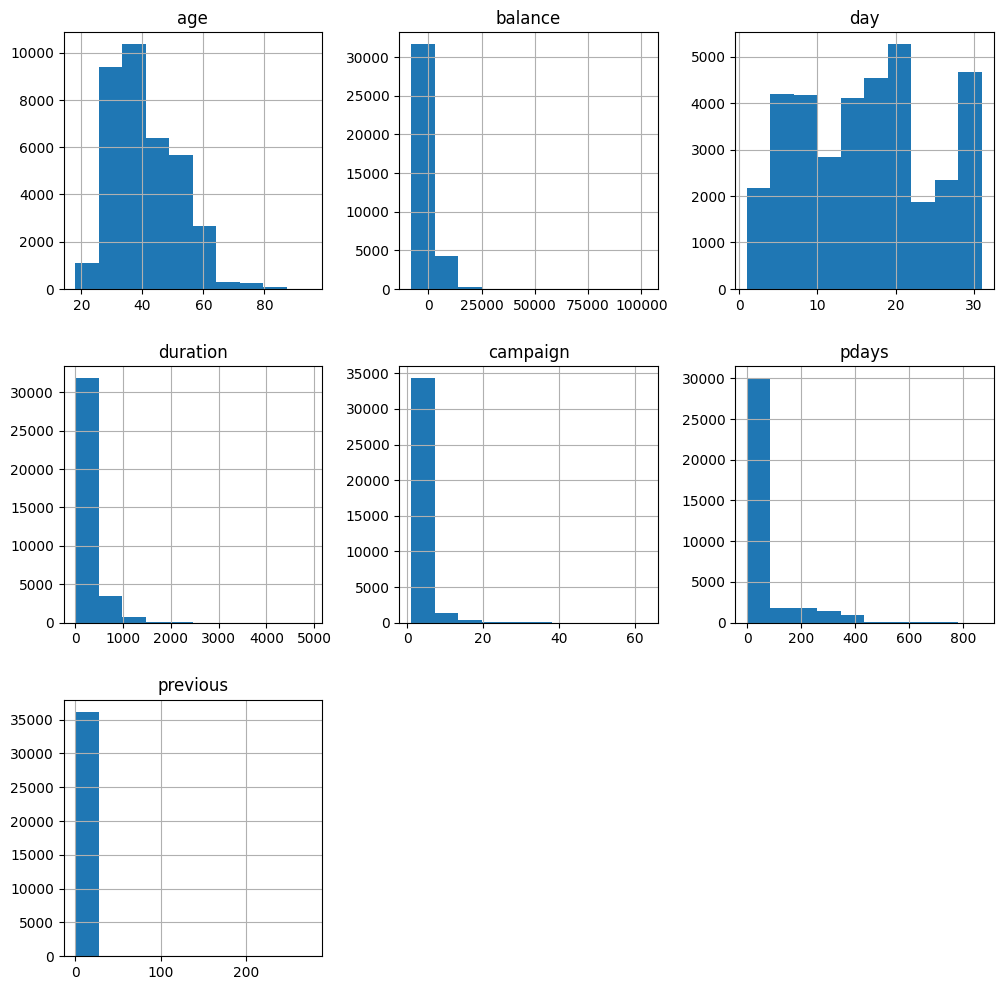

In [8]:
# 3.1 Analisis univariado
df_train.hist(figsize=(12,12))
plt.show()

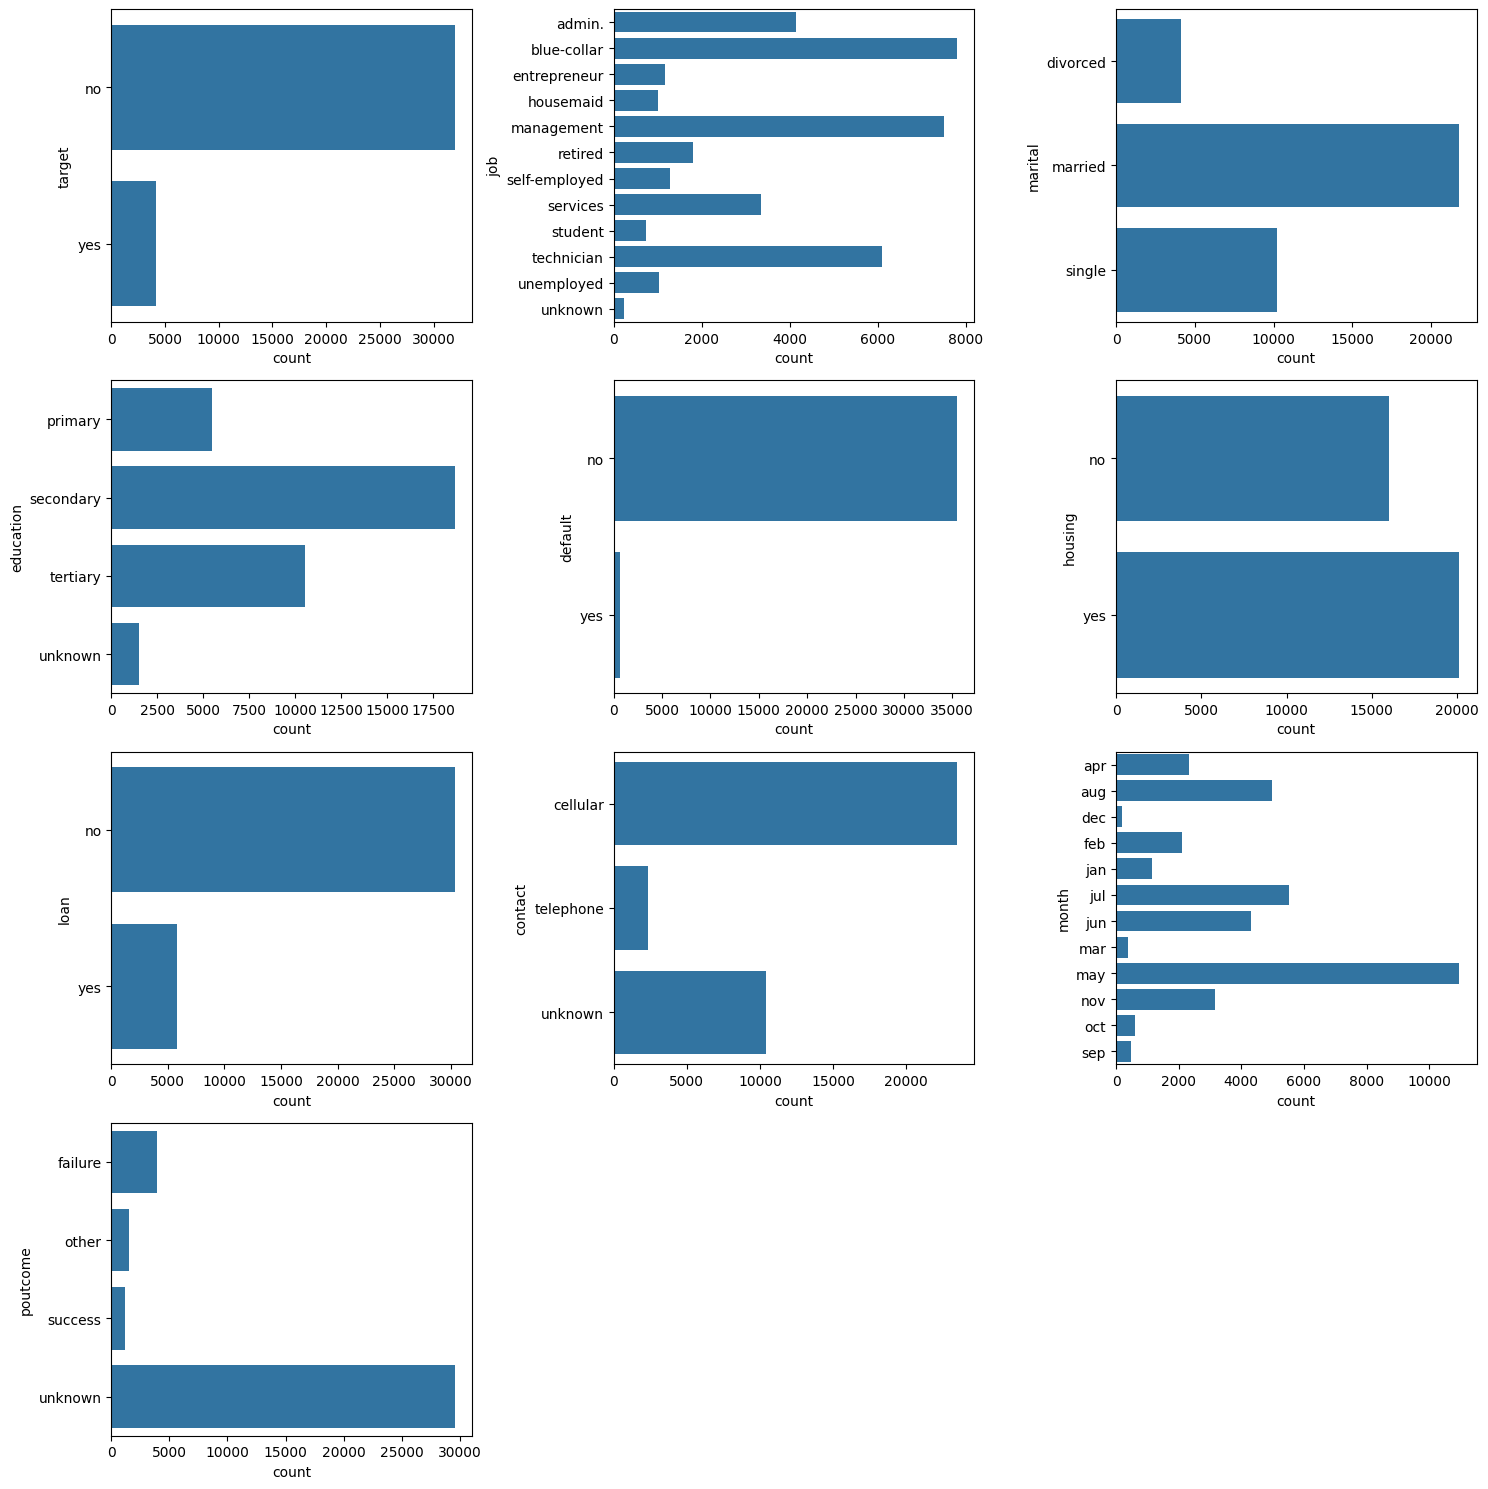

In [13]:
# 3.2 Analisis univariado 'categorico'
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
sns.countplot(data= df_train, y= 'target', ax= ax[0, 0])
sns.countplot(data= df_train, y= 'job', ax= ax[0, 1])
sns.countplot(data= df_train, y= 'marital', ax= ax[0, 2])
sns.countplot(data= df_train, y= 'education', ax= ax[1, 0])
sns.countplot(data= df_train, y= 'default', ax= ax[1, 1])
sns.countplot(data= df_train, y= 'housing', ax= ax[1, 2])
sns.countplot(data= df_train, y= 'loan', ax= ax[2, 0])
sns.countplot(data= df_train, y= 'contact', ax= ax[2, 1])
sns.countplot(data= df_train, y= 'month', ax= ax[2, 2])
sns.countplot(data= df_train, y= 'poutcome', ax= ax[3, 0])

# Eliminar fig ax[3,1], fig ax[3,1], porque tenemos 10 figs
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
plt.tight_layout()
plt.show()

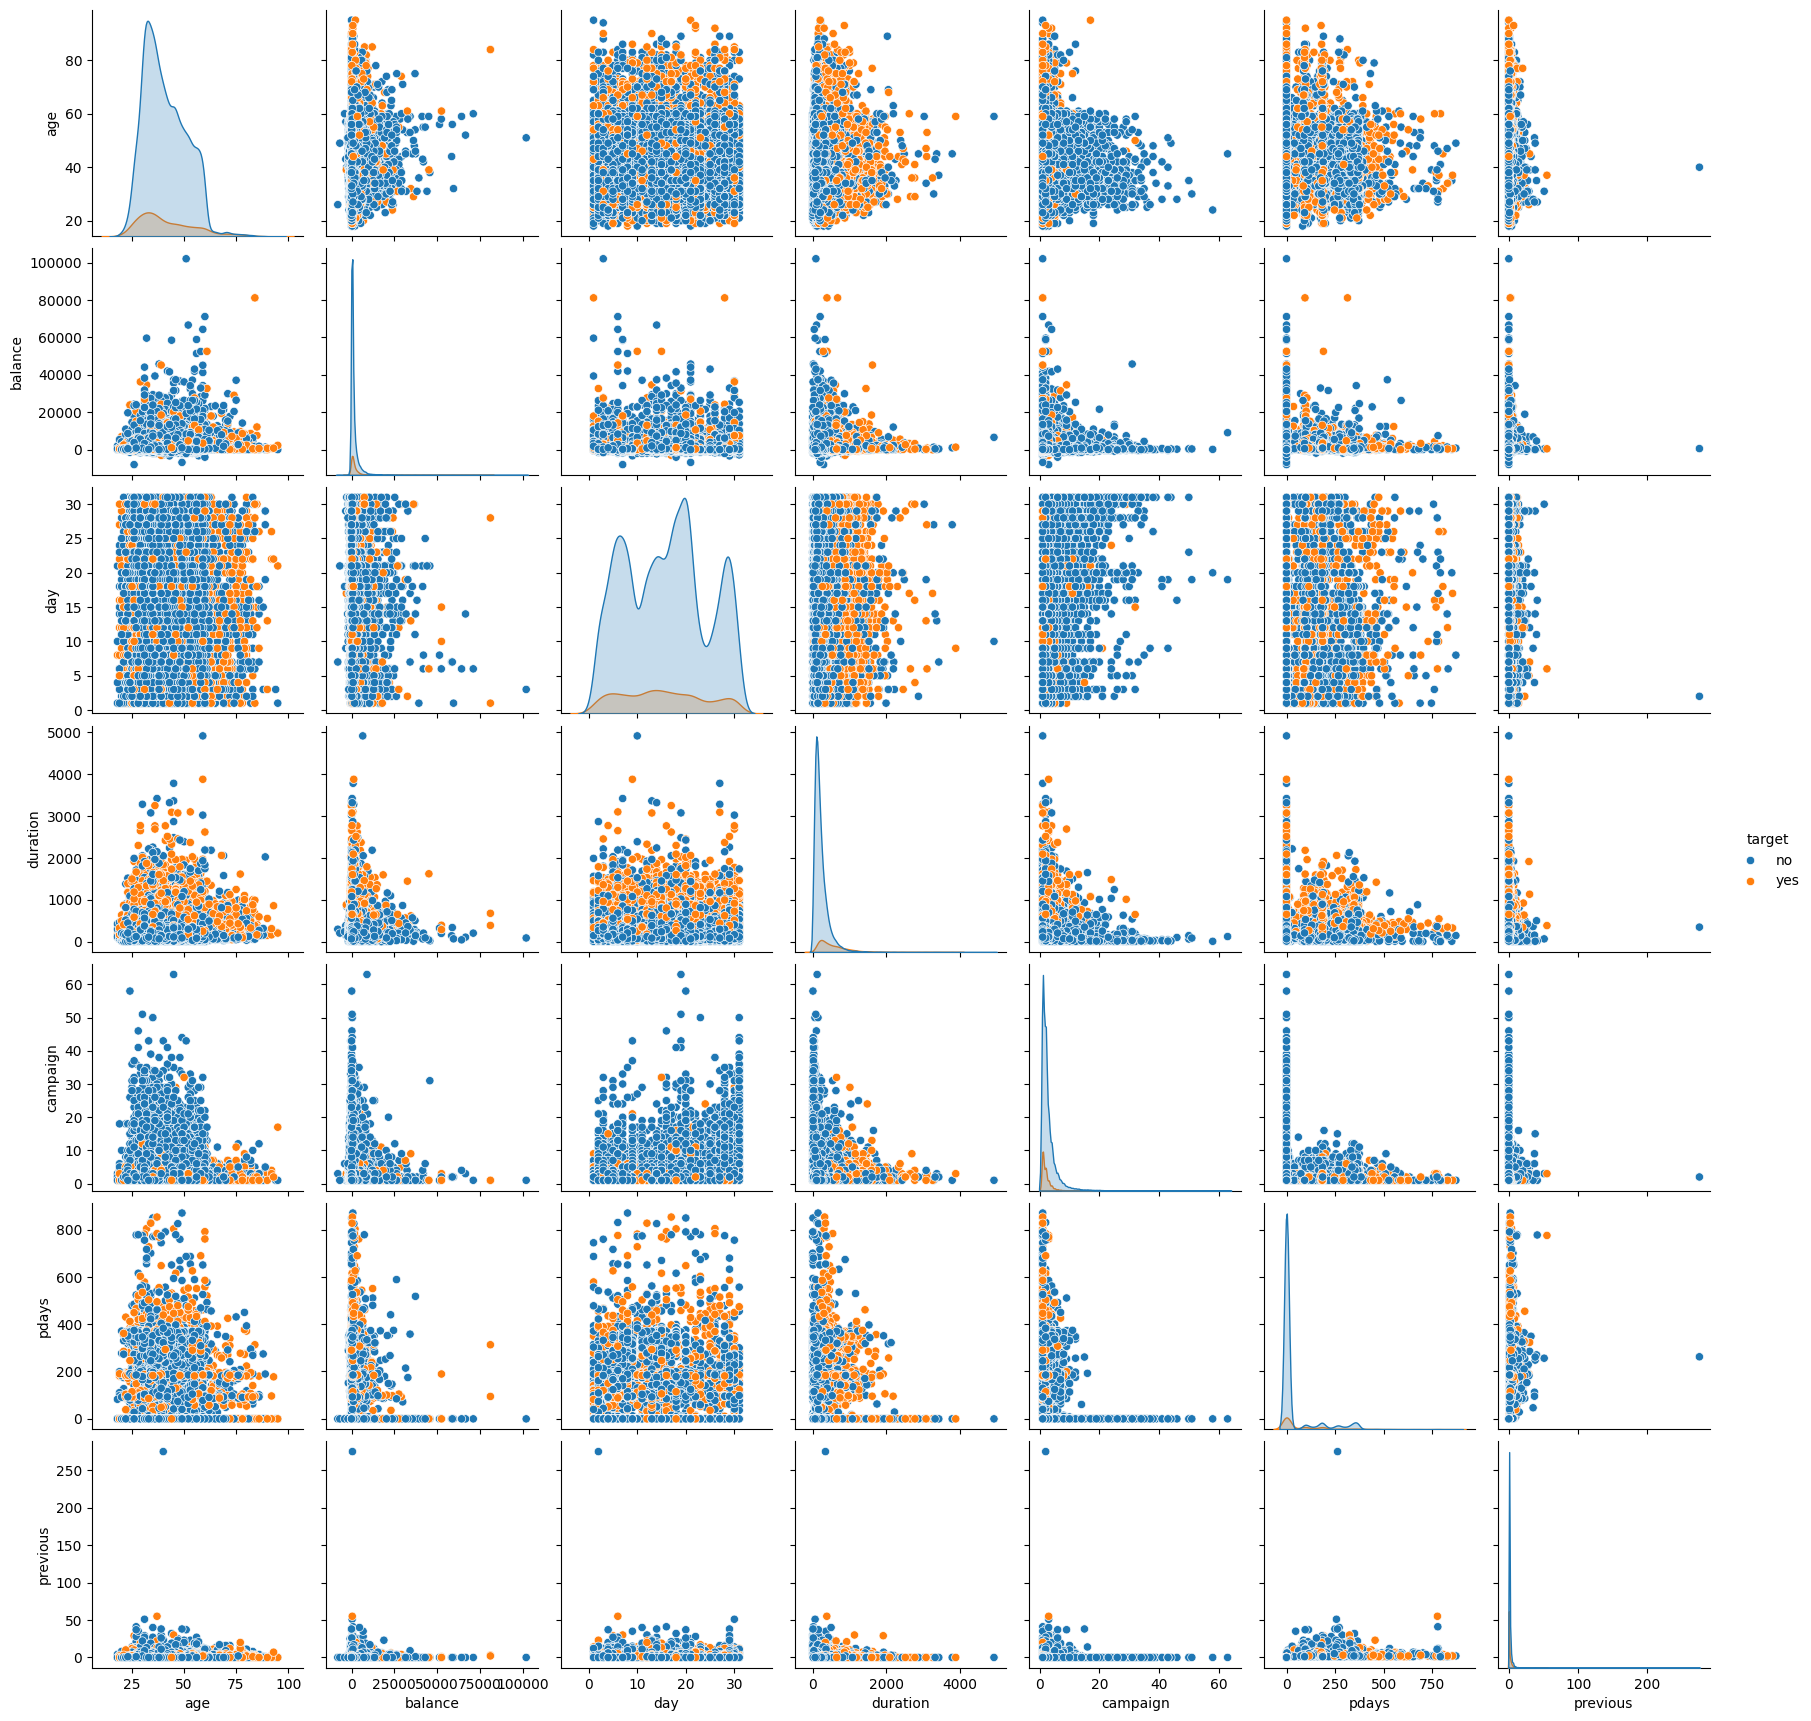

In [14]:
# 3.3 Analisis bivariado
sns.pairplot(df_train, hue='target')
plt.show()